# Generation of Synthetic Networks using the `CRep` Algorithm

In this tutorial, we show how to use the _Probabilistic Generative Models_ (`probinet`) package for generating synthetic network data. 

We use the `CRep` (**C**ommunity and **Re**ci**p**rocity) algorithm {cite}`safdari2021generative`, which is a probabilistic generative method designed to model directed networks. The main assumption of this approach is that communities and reciprocity are the main mechanisms for tie formation. 

Let's first configure the logger to show the information about the execution of the algorithms.

In [1]:
# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.INFO)

## Generating a synthetic network using the `CRep` algorithm

We start by loading the configuration file for the `CRep` algorithm. This file contains the parameters needed to generate the synthetic network. The configuration file is in YAML format and is included in the `probinet` package.

In [2]:
# Import the `open_binary` function from the `importlib.resources` module
# This function is used to open a binary file included in a package
from importlib.resources import open_binary

# Import the `yaml` module to convert the data from a YAML formatted string into a Python dictionary
import yaml

# Define the path to the configuration file for the `CRep` algorithm
config_path = "setting_syn_data_CRep.yaml"

# Open the configuration file for the `CRep` algorithm
with open_binary("probinet.data.model", config_path) as fp:
    # Load the content of the configuration file into a dictionary
    synthetic_configuration = yaml.load(fp, Loader=yaml.Loader)

In [3]:
synthetic_configuration

{'N': 600,
 'K': 3,
 'eta': 0.5,
 'avg_degree': 20,
 'ExpM': None,
 'over': 0.0,
 'corr': 0.0,
 'seed': 0,
 'alpha': 0.1,
 'ag': 0.1,
 'beta': 0.1,
 'Normalization': 0,
 'structure': 'assortative',
 'end_file': '',
 'out_folder': '../data/input/',
 'output_parameters': True,
 'output_adj': True,
 'outfile_adj': None}

As we can see in the dictionary, the reciprocity coefficient `eta` is set to 0.5, meaning that the network will have a moderate level of reciprocity. Nevertheless, we are interested in generating a network with a higher level of reciprocity, thus we increase this value to 0.8. We also modify some details regarding the output of the algorithm.

In [4]:
# Increase the reciprocity coefficient
synthetic_configuration["eta"] = 0.8
# The flag `output_parameters` determines whether the models parameters
# should be saved to a file
synthetic_configuration["output_parameters"] = False
# The flag `output_adj` determines whether the adjacency matrix should
# be saved to a file
synthetic_configuration["output_adj"] = True
# The argument `outfile_adj` determines the name of the file for the
# adjacency matrix
synthetic_configuration["outfile_adj"] = "syn_dataframe.dat"
# The argument `out_folder` determines the output folder for the adjacency
# matrix
synthetic_configuration["out_folder"] = "tutorial_outputs/CRep_synthetic/"

Once the parameters are set, we can generate a synthetic network using the `GM_reciprocity` class. For a better understanding of the structure of the package and its configuration, we invite the reader to take a look at the tutorial on the [`MTCOV` algorithm](./MTCOV.ipynb).

In [5]:
# Load the `GM_reciprocity` class from the `probinet.synthetic.reciprocity` module
from probinet.synthetic.reciprocity import GM_reciprocity

# Define the class `gen` as an instance of the `GM_reciprocity` class using the
# configuration parameters
gen = GM_reciprocity(**synthetic_configuration)

We can check that the model parameters have been set correctly as attributes of the `gen` object.

In [6]:
gen.__dict__

{'N': 600,
 'K': 3,
 'avg_degree': 20,
 'seed': 0,
 'rng': RandomState(MT19937) at 0x7BD95787A640,
 'alpha': 0.1,
 'ag': 0.1,
 'beta': 0.1,
 'end_file': '',
 'out_folder': 'tutorial_outputs/CRep_synthetic/',
 'output_parameters': False,
 'output_adj': True,
 'outfile_adj': 'syn_dataframe.dat',
 'eta': 0.8,
 'ExpM': 6000,
 'over': 0.0,
 'corr': 0.0,
 'Normalization': 0,
 'structure': 'assortative'}

We can now generate a synthetic network using the `reciprocity_planted_network` method, which follows the assumptions of the `CRep` algorithm. Notice that a network generated with this method is directed and weighted. The function returns a MultiDiGraph NetworkX object `G` and its adjacency matrix `A`.

In [7]:
# Generate the network using the `reciprocity_planted_network` method
G, A = gen.reciprocity_planted_network()

INFO:root:Number of links in the upper triangular matrix: 2620
INFO:root:Number of links in the lower triangular matrix: 2597
INFO:root:Sum of weights in the upper triangular matrix: 3018.000
INFO:root:Sum of weights in the lower triangular matrix: 2998.000
INFO:root:Number of possible unordered pairs: 179700
INFO:root:Removed 0 nodes, because not part of the largest connected component
INFO:root:Number of nodes: 600
INFO:root:Number of edges: 5217
INFO:root:Average degree (2E/N): 17.39
INFO:root:Average weighted degree (2M/N): 20.053
INFO:root:Expected reciprocity: 0.885
INFO:root:Reciprocity (networkX) = 0.638
INFO:root:Reciprocity (considering the weights of the edges) = 0.827
INFO:root:Adjacency matrix saved in: tutorial_outputs/CRep_synthetic/syn_dataframe.dat


Notice that, although we set the reciprocity coefficient to 0.8, the actual network reciprocity is 0.638. This mismatch is because `CRep` generates weighted networks. By considering the edge weights, the actual network reciprocity becomes 0.827, pretty close to the desired one. 

We can now inspect how the network looks like.

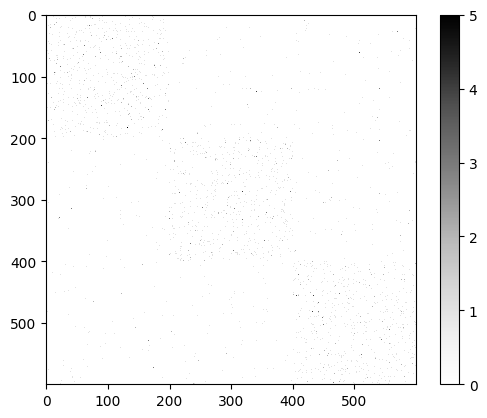

In [8]:
import matplotlib.pyplot as plt

# Plot the adjacency matrix
plt.imshow(A.toarray(), cmap="Greys", interpolation="none")
plt.colorbar()

As we can see, the generated synthetic network reflects an assortative community structure as imposed with the parameter `structure`. In this setting, nodes tend to connect more within their own communities than with nodes from other communities, resulting in higher edge densities within the diagonal blocks of the adjacency matrix. 

When `output_adj=True`, the function saves the network edges as a dataframe into the `syn_dataframe.dat` file in the output folder. The first and the second columns of the dataframe describe the source and the target nodes, respectively, and the last column represents the weight of their interactions. 

In [9]:
import pandas as pd

# Load the dataframe
df = pd.read_csv(
    synthetic_configuration["out_folder"] + synthetic_configuration["outfile_adj"],
    sep=" ",
)
# Print the first 5 rows of the dataframe
df.head()

,source,target,w
0,0,18,1
1,0,50,1
2,0,95,1
3,0,196,1
4,0,204,1


We are all set now! In the next section, we will use the `probinet` package to analyze the network
and extract the community structure and reciprocity coefficient.

## Analyzing the network using the `probinet` package

First, we start by importing the data using the `probinet` package. This means, we will load the data 
from the `syn_dataframe.dat` file and generate the adjacency matrices needed to run the `CRep` algorithm.

In [10]:
from probinet.input.loader import build_adjacency_from_file
from pathlib import Path

# Define the names of the columns in the input file that
# represent the source and target nodes of each edge.
ego = "source"
alter = "target"

# Set the `force_dense` flag to False
force_dense = False

# Set the `binary` flag to False to load the edge weights
binary = False

# Call the `build_adjacency_from_file` function to load the data from the input file
graph_data = build_adjacency_from_file(
    Path(synthetic_configuration["out_folder"])
    / synthetic_configuration["outfile_adj"],
    ego=ego,
    alter=alter,
    force_dense=force_dense,
    binary=binary,
    header=0,
)

To get some information about the data, we can call the `print_graph_stats` function from the
`input.stats` module.

In [11]:
from probinet.input.stats import print_graph_stats

# Extract the list of graphs
A = graph_data.graph_list
# Call the `print_graph_stats` function to print the basic
# statistics of the graphs in the list `A`.
print_graph_stats(A)

Number of nodes = 600
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 5217 / <k> = 17.39
M[0] = 6016 - <k_weighted> = 20.053
Sparsity [0] = 0.014
Reciprocity (networkX) = 0.000


Once the network is loaded, we can give it as input to the `CRep` algorithm to obtain estimates of the latent
variables describing the communities and the reciprocity. 

## Running the model
Finally, we are ready to run the `CRep` model! The way this works is in a two-step process: <br>
1. Initialize the `CRep` model by creating an instance of the `CRep` class.
2. Execute the `fit` method on the created instance to run the algorithm.


In [12]:
# Import the `CRep` class from the `probinet.models.crep` module
from probinet.models.crep import CRep

# Create an instance of the `CRep` class
model = CRep()

# Print all the attributes of the `CRep` instance
# The `__dict__` attribute of an object is a dictionary containing
# the object's attributes.
print(model.__dict__)

{'inf': 10000000000.0, 'err_max': 1e-12, 'err': 0.1, 'num_realizations': 5, 'convergence_tol': 0.0001, 'decision': 10, 'max_iter': 1000, 'plot_loglik': False, 'flag_conv': 'log', '__doc__': '\n    Base class for the models classes that inherit from the ModelBaseParameters class. It contains the\n    methods to check the parameters of the fit method, initialize the parameters, and check for\n    convergence. All the models classes should inherit from this class.\n    ', 'attributes_to_save_names': ['u_f', 'v_f', 'w_f', 'eta_f', 'final_it', 'maxL', 'maxPSL', 'beta_f', 'nodes', 'pibr', 'mupr'], 'u_f': array([], dtype=float64), 'v_f': array([], dtype=float64), 'w_f': array([], dtype=float64), 'use_unit_uniform': False, 'theta': {}, 'normalize_rows': False, 'nodes': [], 'rng': Generator(PCG64) at 0x7BD954D0F840, 'beta_hat': array([], dtype=float64), 'best_r': 0, 'final_it': 0, 'message_for_invalid_initialization': 'The initialization parameter can be either 0 or 1. If 0, the model will be i

Model created! Now, we can run the model using the `fit` method.

In [13]:
# Import the needed modules
import time
import numpy as np

# Get the current time
time_start = time.time()

# Run the `CRep` models
inferred_parameters = model.fit(
    graph_data,
    out_inference=True,
    out_folder=synthetic_configuration["out_folder"],
)

# Print the time elapsed since the start of the `CRep` algorithm
print(f"\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.")

INFO:root:Algorithm successfully converged after 681 iterations with a maximum log-likelihood of -15729.3730.
INFO:root:Inferred parameters saved in: /home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/docs/source/tutorials/tutorial_outputs/CRep_synthetic/theta.npz
INFO:root:To load: theta=np.load(filename), then e.g. theta["u"]



Time elapsed: 23.48 seconds.


Done! The model has been run and the results are stored into the variable `inferred_parameters` and saved into the file `theta_CRep.npz` in the output folder.

## Analyzing the results
We can now retrieve the results from the saved file. 

In [14]:
filename = synthetic_configuration["out_folder"] + "/theta.npz"
# Load the contents of the file into a dictionary
theta = np.load(filename)

In [15]:
# Unpack the latent variables from the results of the `CRep` models
# The `u` variable represents the out-going memberships of the
# nodes in the graph.
# The `v` variable represents the in-coming memberships of the
# nodes in the graph.
# The `w` variable represents the affinity of the communities
# The `eta` variable represents the reciprocity coefficient
u, v, w, eta = theta["u"], theta["v"], theta["w"], theta["eta"]

We can now compare the inferred parameters with the actual ones.

Notice that we don't expect good results in retrieving the communities because we are in a regime
 with high reciprocity. Indeed, as explained in the main reference {cite}`safdari2021generative`,
  the `CRep` algorithm gives  increasingly less  weight to the communities as reciprocity increases, resulting in poor community detection performance when the communities are not fully determining edge formation. On the other hand, it well summarizes the network reciprocity.

In [16]:
import networkx as nx

# Print the actual network reciprocity
print(f"Actual network reciprocity: {np.round(nx.reciprocity(A[0]),3)}")
# Print the inferred reciprocity coefficient
print(f"Inferred reciprocity coefficient: {np.round(eta, 3)}")

Actual network reciprocity: 0.638
Inferred reciprocity coefficient: 0.679


For a more graphical approach on how to investigate the results, we invite the reader to take a
look at the tutorial on the [`JointCRep` algorithm](./JointCRep.ipynb).

Notice also that the `GM_reciprocity` class provides various methods to create synthetic data according different generative assumptions, and the `reciprocity_planted_network` method used in this tutorial is just an example.

## Summary

This tutorial provides a guide on using the  `probinet` package  to  generate synthetic network data. In particular, it uses the `CRep` algorithm, which is a probabilistic generative method designed to model directed networks assuming that communities and reciprocity are the main mechanisms for tie formation.

The tutorial also shows how to analyze the generated network with the `probinet` package, and how to infer the latent variables using the `CRep` algorithm. In addition, it guides the user on how to import the inferred results.
